# Playground for KL mode compression

In [1]:
# Show plots inline, and load main getdist plot module and samples class
#Change
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
here = './' 
temp_path = os.path.realpath(os.path.join(os.getcwd(), here+'tensiometer'))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
from tensiometer import utilities
from tensiometer import gaussian_tension

In [2]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = here+'/tensiometer/test_chains/'
# the data chain:
settings = {'ignore_rows':0, 'smooth_scale_1D':0.3, 'smooth_scale_2D':0.3}
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True, settings=settings)
#chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True, settings=settings)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True, settings=settings)

In [3]:
# add useful parameters:
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(p.omegach2/(p.H0/100.)**2, name='omegac', label='\\Omega_c')
    ch.addDerived(p.omegabh2/(p.H0/100.)**2, name='omegab', label='\\Omega_b')
    ch.addDerived(p.sigma8*np.sqrt(p.omegam/0.3), name='S8', label='S_8')
    ch.addDerived(p.sigma8*5, name='sigma8_5', label='\\sigma_8 5')
    ch.addDerived(p.H0/100, name='h', label='h')
    # update after adding all parameters:
    ch.updateBaseStatistics()

In [4]:
# decide the parameters to use:
param_names = ['omegam', 'omegab', 'sigma8', 'ns', 'H0']

In [5]:
# add log of the chosen parameters:
for ch in [chain, prior_chain]:
    for name in param_names:
        ch.addDerived(np.log(ch.samples[:, ch.index[name]]), name='log_'+name, label='\\log'+ch.getParamNames().parWithName(name).label)
    # update after adding all parameters:
    ch.updateBaseStatistics()

In [6]:
# now we generate the Gaussian approximation:
g_param_names = ['log_'+name for name in param_names]
n_samples = 100000
print(g_param_names)
# create the Gaussian:
gauss = gaussian_tension.gaussian_approximation(chain, param_names=g_param_names)
chain_gauss = gauss.MCSamples(size = n_samples)
prior_gauss = gaussian_tension.gaussian_approximation(prior_chain, param_names=g_param_names)
prior_chain_gauss = prior_gauss.MCSamples(size = n_samples)

['log_omegam', 'log_omegab', 'log_sigma8', 'log_ns', 'log_H0']


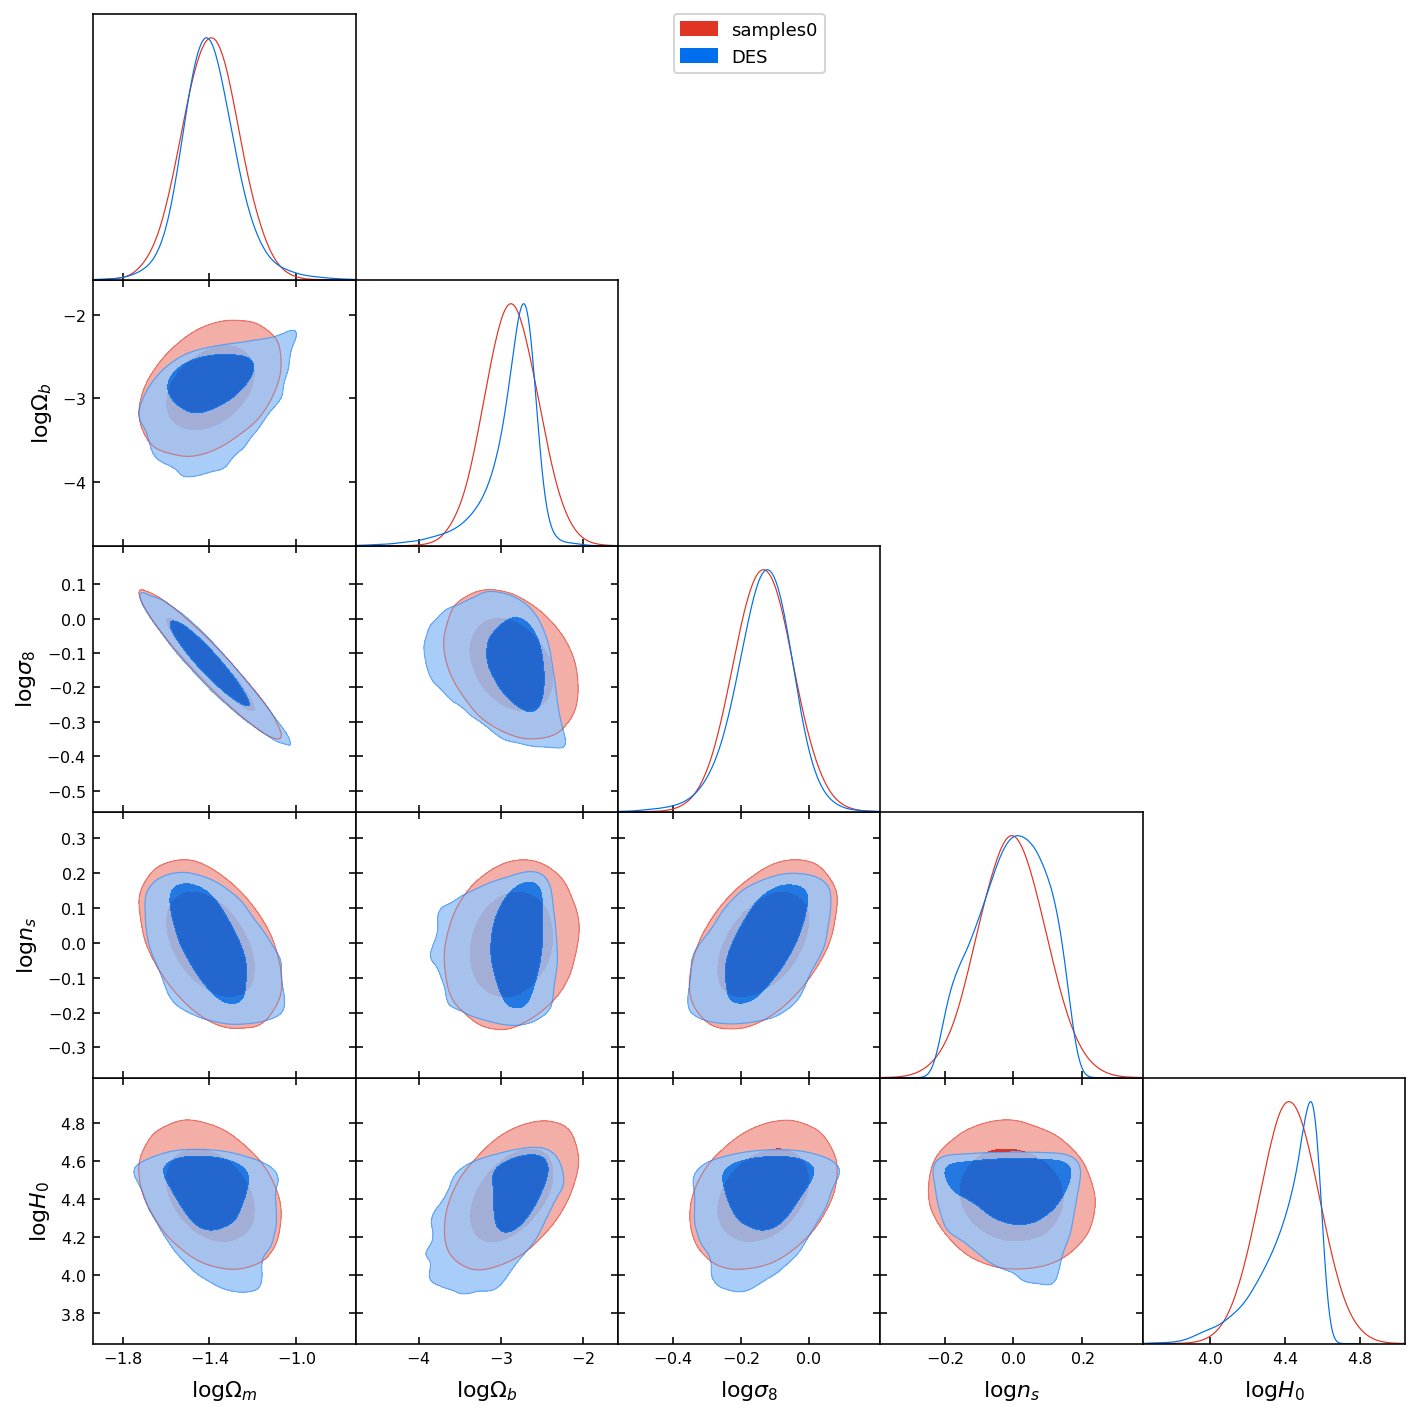

In [7]:
# look qualitatively at how the Gaussian approximation is doing:
g = plots.get_subplot_plotter()
g.triangle_plot([chain_gauss, chain], params=g_param_names, filled=True)

In [8]:
# after generating the two perfectly Gaussian chains we can compute here the other parameters as derived:
for ch in [chain_gauss, prior_chain_gauss]:
    p = ch.getParams()
    # the original parameters:
    for ind, name in enumerate(g_param_names):
        ch.addDerived(np.exp(ch.samples[:, ch.index[name]]), name=str(name).replace('log_',''), label=str(ch.getParamNames().parWithName(name).label).replace('\\log',''))
    # label=ch.getParamNames().parWithName(name).label.replace('\\log ','')
    ch.updateBaseStatistics()

In [9]:
print(chain_gauss.getParamNames().labels())

['\\log\\Omega_m', '\\log\\Omega_b', '\\log\\sigma_8', '\\logn_s', '\\logH_0', '\\Omega_m', '\\Omega_b', '\\sigma_8', 'n_s', 'H_0']


In [10]:
# define the parameter transformation:
A = np.array([[ 1, -1, 0, 0, 0],
              [ 0, 1, 0, 0, 0],
              [ 0, 0, 1, 0, 0],
              [ 0, 0, 0, 1, 0],
              [ 0, 0, 0, 0, 1]])

In [11]:
# verify that it is not orthogonal:
np.linalg.inv(A)

array([[1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [12]:
theta = np.array([1,.5,0,0,0])
theta_prime = np.dot(A,theta)
print(theta_prime)

[0.5 0.5 0.  0.  0. ]


In [13]:
covariance = chain.cov(pars=g_param_names)
# not using localization:
prior_covariance = prior_chain.cov(pars=g_param_names)
# using localization:
#prior_covariance = gaussian_tension.get_localized_covariance(prior_chain, chain, g_param_names)
tilde_covariance = np.dot(np.dot(A, covariance), A.T)
tilde_prior_covariance = np.dot(np.dot(A, prior_covariance), A.T)

In [14]:
# do PCA of the two covariances:
PCA_eig, PCA_eigv = np.linalg.eigh(covariance)
tilde_PCA_eig, tilde_PCA_eigv = np.linalg.eigh(tilde_covariance)

In [85]:
# do KL of the two covariances:
KL_eig, KL_eigv = utilities.KL_decomposition(prior_covariance, covariance)
# sorth the KL modes:
idx = np.argsort(KL_eig)[::-1]
KL_eig, KL_eigv = KL_eig[idx], KL_eigv[:, idx]

In [86]:
# do initial calculations:
inv_KL_eigv = utilities.QR_inverse(KL_eigv.T)
inv_cov_p = utilities.QR_inverse(covariance)

In [99]:
# compute joint covariance contributions:
temp = inv_KL_eigv*np.dot(inv_cov_p, inv_KL_eigv.T).T
contributions = (np.abs(temp.T)/np.sum(np.abs(temp), axis=1)).T

In [108]:
Psi_i = inv_KL_eigv[0, :]
np.dot(inv_cov_p, inv_KL_eigv[0, :])

array([26.97460536, -2.03393841, 34.1205034 ,  3.33507225,  3.36746035])

In [125]:
inv_KL_eigv[0, :]*np.dot(inv_cov_p, inv_KL_eigv[0, :])

array([ 6.20989638e-01, -9.16007583e-03,  3.96754668e-01,  3.49592354e-04,
       -8.93382204e-03])

In [126]:
KL_eigv[:, 1]*np.dot(covariance, KL_eigv[:, 1])

array([ 0.69929613, -0.23077099,  0.78342886,  0.03441995, -0.28637394])

In [127]:
KL_eigv[:, 0]*np.dot(covariance, KL_eigv[:, 0])

array([ 6.20989638e-01, -9.16007583e-03,  3.96754668e-01,  3.49592354e-04,
       -8.93382204e-03])

In [124]:
KL_eigv[:, 1]*np.dot(pippo, KL_eigv[:, 1])

array([2.28289403e-01, 1.86482783e+06, 2.70953459e-01, 2.87537509e-01,
       7.05409007e-02])

In [82]:
np.sum(np.abs(temp), axis=1)

array([1.        , 1.        , 2.07552779, 2.03428987, 1.0361878 ])

In [98]:
np.abs(temp[:, 0].T)/np.sum(np.abs(temp), axis=1)

array([0.59930221, 0.34375442, 0.164651  , 0.00148393, 0.01996803])

In [97]:
print(gaussian_tension.KL_PCA(prior_chain, chain, param_names=g_param_names, localize=False)[0])

KLCA for 5 parameters:

         1 : \log\Omega_m
         2 : \log\Omega_b
         3 : \log\sigma_8
         4 : \logn_s
         5 : ln(\logH_0)

KL amplitudes - 1 (covariance/variance improvement per mode)
KLC 1: 1417.7408 (  3765.3 %)
KLC 2:  47.3396 (   688.0 %)
KLC 3:  35.2018 (   593.3 %)
KLC 4:   0.4037 (    63.5 %)
KLC 5:   0.2701 (    52.0 %)

KL-modes
  1: -27.019   2.048 -34.122  -3.381 -14.647
  2:  -8.359   4.426  12.850 -14.187 -35.084
  3:  -4.269   5.207   4.029  -8.861 -42.924
  4:   0.509   1.084  -0.530   6.093  16.161
  5:   0.784   0.419  -0.858  -7.287  13.423

Parameter contribution to KL-mode variance
 mode number :       1       2       3       4       5
  log_omegam :   0.597   0.346   0.168   0.013   0.040
  log_omegab :   0.009   0.103   0.426   0.269   0.044
  log_sigma8 :   0.384   0.381   0.093   0.011   0.030
      log_ns :   0.000   0.018   0.011   0.322   0.600
  log_log_H0 :   0.010   0.152   0.301   0.384   0.285

KL Principal Components
KLC 1: 141

In [44]:
inv_KL_eigv*np.dot(inv_cov_p, inv_KL_eigv.T).T

array([1.11372134e+00, 1.34140854e+00, 3.13798394e+01, 5.13426298e+01,
       1.41914677e+03])

In [51]:
theta_p = chain.getMeans(pars=[chain.index[name] for name in g_param_names])
theta_pi = prior_chain.getMeans(pars=[prior_chain.index[name] for name in g_param_names])

In [53]:
thetaprime = theta_p+10*np.ones(len(theta_p))
thetaprime

array([ 8.60480569,  7.12463959,  9.86616167,  9.99544545, 14.4214017 ])

In [55]:
thetaprime = theta_p-theta_pi
thetaprime

array([-1.80485954e+00, -9.77916862e-01,  1.66333047e-01, -2.49967312e-04,
        4.72254447e-01])

In [56]:
np.sum(np.dot(KL_eigv.T, thetaprime)**2)

1636.4640376830412

In [58]:
np.dot(KL_eigv.T, thetaprime)**2

array([8.32310387e-02, 1.34426567e-02, 2.30255421e+00, 7.92200861e+01,
       1.55484472e+03])

In [61]:
np.sum(KL_eigv.T[-1, :]*thetaprime)**2

1554.844723656358

In [62]:
KL_eigv.T[-1, :]*thetaprime/np.sum(KL_eigv.T[-1, :]*thetaprime)

array([ 1.23468166e+00, -5.04424557e-02, -1.43929713e-01,  2.11419457e-05,
       -4.03306327e-02])

In [31]:
np.dot(np.dot(theta_p, np.linalg.inv(covariance)), theta_p)

5051.161245326014